In [2]:
import os
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


In [2]:

def generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences):
    sequences = []
    for _ in range(num_sequences):
        seq, conditions = [], []
        match_positions = random.sample(range(n, seq_length), matches)
        match_positions.sort()

        for i in range(seq_length):
            if i in match_positions:
                seq.append(seq[i - n])
                conditions.append('m')
            else:
                random_letter = random.choice(alphabet)
                while i > n and seq[i - n] == random_letter:
                    random_letter = random.choice(alphabet)
                seq.append(random_letter)
                conditions.append('-')

        sequences.append((''.join(seq), ''.join(conditions)))

    return sequences

def save_sequences_to_json(sequences, output_file):
    data = []
    for seq, conditions in sequences:
        data.append({
            "input": seq,
            "target": conditions
        })
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)


In [3]:

alphabet = 'bcdfghjklnpqrstvwxyz'
seq_length = 24
matches = 8
num_sequences_train = 800
num_sequences_test = 200


In [4]:
# for n in [1, 2, 3, 4, 5, 6]:
#     sequences_train = generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences_train)
#     sequences_test = generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences_test)

#     save_sequences_to_json(sequences_train, f'nback_{n}_train.json')
#     save_sequences_to_json(sequences_test, f'nback_{n}_test.json')

In [5]:
# Define the dataset
class NBackDataset(Dataset):
    def __init__(self, json_file, char_to_idx, label_to_idx):
        self.data = []
        with open(json_file, 'r') as f:
            data_json = json.load(f)
            for item in data_json:
                input_seq = [char_to_idx[char] for char in item['input']]
                target_seq = [label_to_idx[label] for label in item['target']]
                self.data.append((torch.tensor(input_seq), torch.tensor(target_seq)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [6]:
class SimpleDecoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads):
        super(SimpleDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=model_dim, num_heads=num_heads)

    def forward(self, x, mask):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        return attn_output

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, max_seq_len):
        super(DecoderOnlyTransformer, self).__init__()
        self.embedding = nn.Embedding(input_dim, model_dim)
        self.positional_encoding = nn.Embedding(max_seq_len, model_dim)

        self.layers = nn.ModuleList([SimpleDecoderLayer(model_dim, num_heads) for _ in range(num_layers)])
        self.unembed = nn.Linear(model_dim, output_dim)

    def forward(self, x, mask):
        seq_len = x.size(1)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)
        x = x.transpose(0, 1)
        positions = positions.transpose(0, 1)
        x = self.embedding(x) + self.positional_encoding(positions)

        for layer in self.layers:
            x = layer(x, mask)
            
        logits = self.unembed(x)
        return logits

In [3]:
# Hyperparameters
alphabet = 'bcdfghjklnpqrstvwxyz'
conditions = ['-', 'm']
char_to_idx = {char: idx for idx, char in enumerate(alphabet)}
label_to_idx = {label: idx for idx, label in enumerate(conditions)}
input_dim = len(alphabet)
model_dim = 512
num_heads = 1
num_layers = 1
output_dim = 2  # Number of classes ('m':1 and '-':0)
max_seq_len = 24
learning_rate = 1e-4
num_epochs = 10
batch_size = 32
num_models = 50

In [8]:
def generate_causal_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

In [9]:
# For n = 1,2,3, train 50 different models, record the training loss each epoch, and the test loss and accuracy for each model (we will plot the average test loss and accuracy for each n)
# save each model after training
all_results = {}
for n in range(1, 7):
    train_dataset = NBackDataset(f'nback_{n}_train.json', char_to_idx, label_to_idx)
    test_dataset = NBackDataset(f'nback_{n}_test.json', char_to_idx, label_to_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device('cpu')

    for m in range(num_models): # train num_models different models
        print(f"Training model {m+1} for n = {n}")
        model = DecoderOnlyTransformer(input_dim, model_dim, num_heads, num_layers, output_dim, max_seq_len).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        all_results['{}back_model{}'.format(n, m)] = {'train_loss': [], 'test_loss': 0, 'test_accuracy': 0}

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for src, tgt in train_loader:
                src, tgt = src.to(device), tgt.to(device)
                causal_mask = generate_causal_mask(src.size(1)).to(device)

                # Forward pass
                outputs = model(src, causal_mask)
                outputs = outputs.permute(1,2,0)

                # Compute the loss
                loss = criterion(outputs, tgt)
                train_loss += loss.item()

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(train_loader)
            all_results['{}back_model{}'.format(n, m)]['train_loss'].append(train_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Evaluate the model
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            eval_loss = 0
            for src, tgt in test_loader:
                src, tgt = src.to(device), tgt.to(device)
                causal_mask = generate_causal_mask(src.size(1)).to(device)

                # Forward pass
                outputs = model(src, causal_mask)
                outputs = outputs.permute(1,2,0)

                # Compute the loss
                loss = criterion(outputs, tgt)
                eval_loss += loss.item()

                # Get the predicted labels
                predicted = torch.argmax(outputs, dim=1)
                total += tgt.size(0) * tgt.size(1)
                correct += (predicted == tgt).sum().item()

            eval_loss /= len(test_loader)
            accuracy = correct / total
            all_results['{}back_model{}'.format(n, m)]['test_loss'] = eval_loss
            all_results['{}back_model{}'.format(n, m)]['test_accuracy'] = accuracy
            print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Training model 1 for n = 1
Epoch 1/10, Train Loss: 0.6315
Epoch 2/10, Train Loss: 0.6010
Epoch 3/10, Train Loss: 0.4621
Epoch 4/10, Train Loss: 0.2947
Epoch 5/10, Train Loss: 0.2503
Epoch 6/10, Train Loss: 0.2356
Epoch 7/10, Train Loss: 0.2310
Epoch 8/10, Train Loss: 0.2272
Epoch 9/10, Train Loss: 0.2195
Epoch 10/10, Train Loss: 0.2150
Test Loss: 0.2445, Test Accuracy: 0.8879
Training model 2 for n = 1
Epoch 1/10, Train Loss: 0.6308
Epoch 2/10, Train Loss: 0.5942
Epoch 3/10, Train Loss: 0.4636
Epoch 4/10, Train Loss: 0.3112
Epoch 5/10, Train Loss: 0.2269
Epoch 6/10, Train Loss: 0.1928
Epoch 7/10, Train Loss: 0.1819
Epoch 8/10, Train Loss: 0.1772
Epoch 9/10, Train Loss: 0.1742
Epoch 10/10, Train Loss: 0.1705
Test Loss: 0.1939, Test Accuracy: 0.9273
Training model 3 for n = 1
Epoch 1/10, Train Loss: 0.6384
Epoch 2/10, Train Loss: 0.6174
Epoch 3/10, Train Loss: 0.6101
Epoch 4/10, Train Loss: 0.5964
Epoch 5/10, Train Loss: 0.5615
Epoch 6/10, Train Loss: 0.4943
Epoch 7/10, Train Loss: 0.395

In [10]:
# save all_results to a json file
with open('trained_models/1_layer_1_head_all_results.json', 'w') as f:
    json.dump(all_results, f, indent=4)

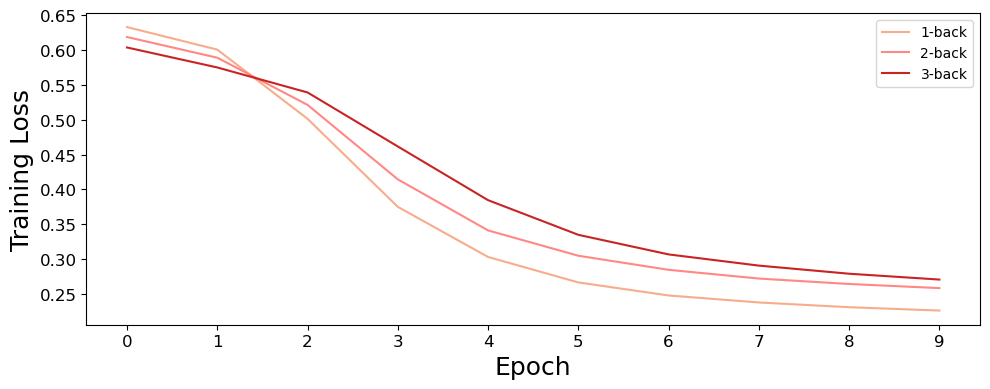

In [52]:
# plot the training loss across epochs for each n (only plot the average loss for each n)
colors = ['#F8AC8C' ,'#FF8884', '#C82423']
plt.figure(figsize=(10, 4))
avg_loss = []
for n in range(1, 4):
    loss = np.mean([all_results['{}back_model{}'.format(n, m)]['train_loss'] for m in range(num_models)], axis=0)
    avg_loss.append(loss)
    plt.plot(range(num_epochs), loss, label=f'{n}-back', color=colors[n-1])
plt.xlabel('Epoch',fontsize=18)
plt.xticks(range(num_epochs), fontsize=12)
plt.ylabel('Training Loss',fontsize=18)
plt.legend()
plt.tick_params(axis='both', which='both', labelsize=12)
plt.tight_layout()
plt.show()